In [13]:
from io import BytesIO
import pandas as pd
import datetime
import vk_api
import os
import requests
import json
import random
import numpy as np
import plotly.express as px
import os

from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from tqdm.auto import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sys


import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
from datetime import timedelta

import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (16, 9)

Проект: вариант 1
Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.

Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.

Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

### TAKS 1

In [28]:
time_reg = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-g-zigora-23/shared/problem1-reg_data.csv", sep=";")

In [29]:
time_reg

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [30]:
time_enter_game = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-g-zigora-23/shared/problem1-auth_data.csv", sep=";")

In [31]:
time_enter_game

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
...,...,...
9601008,1600874034,1110618
9601009,1600874086,1110619
9601010,1600874139,1110620
9601011,1600874191,1110621


In [32]:
df = time_reg.merge(time_enter_game, on = 'uid')
df.head()

,reg_ts,uid,auth_ts
0,911382223,1,911382223
1,932683089,2,932683089
2,932683089,2,932921206
3,932683089,2,933393015
4,932683089,2,933875379


In [33]:
df['reg_ts'] = df['reg_ts'].apply(datetime.fromtimestamp).dt.date

In [ ]:
df['auth_ts'] = df['auth_ts'].apply(datetime.fromtimestamp).dt.date

In [ ]:
df[['reg_ts', 'auth_ts']].max()

In [ ]:
df[['reg_ts', 'auth_ts']].min()


1.  Напишем функцию которая итерируется по датафрейму, и считает вовлеченность пользователей, для этого мы создадим колонку diff и произведем вычисление из даты входа в игру вычитаем дату регистрации, тем самым найдем retention.
2. Удалим нулевой индекс так как он в себе аккумулировал все посещения приложения, больше он нам не понадобится, и дату с которой отсутсвуют данные. Это первый столбец и псоледняя строка

In [ ]:
def retention(start_date, df):
    df['reg_ts'] = df['reg_ts'].apply(datetime.fromtimestamp).dt.date
    df['auth_ts'] = df['auth_ts'].apply(datetime.fromtimestamp).dt.date
    days_df['diff'] = days_df["auth_ts"] - days_df["reg_ts"]
    pivot = df.pivot_table(index = start_date, columns = 'diff', values = uid, aggfunc = 'nunique')
    pivot = round(pivot.divide(pivot.iloc[: , 0], axis = 'index').iloc[:-1, 1:], 4)
    

3. Работа с датафреймом ограничивается 10 днями, так как по моему мнению, этого времени достаточно для ознакомления с данными, так как в игре добавлено событие (event), есть смысл сделать несколько периодичностей. Например,  Когорта№1 - 7 дней,Когорта№2 - 14 дней,               Когорта 3№ - 31 день,если больше 31 дня то ошибка, если нет то оставляем, и с 29-31 дни будут относиться к когорте номер 3).

In [ ]:
# df['reg_ts'] = df['reg_ts'].apply(datetime.fromtimestamp).dt.date
# df['auth_ts'] = df['auth_ts'].apply(datetime.fromtimestamp).dt.date
df = df[df["reg_ts"]>=pd.to_datetime("2020-9-13").date()]
df['diff'] = df["auth_ts"] - df["reg_ts"]
df = df[df['diff'] <= pd.to_timedelta("10 days")]
pivot = df.pivot_table(index = "reg_ts", columns = 'diff', values = "uid", aggfunc=lambda x: len(x.unique()))
pivot = round(pivot.divide(pivot.iloc[: , 0], axis = 'index').iloc[:-1, 1:], 4)

4. Визуализируем когортный анализ за 10 дней. Цветовая палитра розовая в трех оттенках. Итог: График визуализирует retention  в какой день зашло больше всего людей которые зарегестрировались в определённую дату.

In [ ]:
plt.figure(figsize = (30, 15))
cmap = ['#fbe2e8', '#eaadbd', '#c98496']
sns.heatmap(pivot, 
                    annot = True, 
                    xticklabels = pivot.columns.astype('str'), 
                    yticklabels = pivot.index.astype('str'),
                    cmap = cmap,
                    fmt='.2%',
                    annot_kws = dict(
                        color = 'black',
                        fontsize = 16),
                    linewidth = 1,
                    linecolor = 'black',
                    cbar_kws = dict( extend = 'min',
                        ticks = np.arange(1, 1))
           )
plt.xlabel(' ')
plt.ylabel(' ')
plt.xticks(color = 'black',
                   fontsize = 16,
                   rotation = 90)
plt.yticks(rotation = 0,
                   color = 'black',
                   fontsize = 16)
plt.title(label = f'''Когортный анализ за {df['diff'].max().days} дней''',
                  color = 'black',
                  fontsize = 20,
                  x = 0.5)
plt.show()

### TASK 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [34]:
df = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-g-zigora-23/final_project/Проект_1_Задание_2.csv", sep=";")

In [35]:
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


### mini Task-1 
Узнаем у какой группы преимущество в количестве платящих пользователей

In [36]:
df.query("testgroup == \"a\" and revenue > 0")

,user_id,revenue,testgroup
72,73,351,a
341,342,290,a
385,386,250,a
416,417,37324,a
712,713,255,a
...,...,...,...
404304,404305,360,a
404315,404316,262,a
404543,404544,369,a
404602,404603,251,a


In [37]:
1928/202103

0.009539690157988749

In [38]:
df.query("testgroup == \"b\" and revenue > 0")

,user_id,revenue,testgroup
160,161,3797,b
377,378,3768,b
386,387,3527,b
551,552,2038,b
913,914,3902,b
...,...,...,...
403843,403844,3383,b
403994,403995,2793,b
404161,404162,2316,b
404193,404194,2998,b


In [39]:
1805 / 202667

0.008906235351586593

Сравним количество 
пользователей и визуализируем

In [40]:
gruppa = df \
    .groupby('testgroup', as_index = False) \
    .agg({'user_id' : 'count'}) \
    .rename(columns = {'user_id' : 'count'})

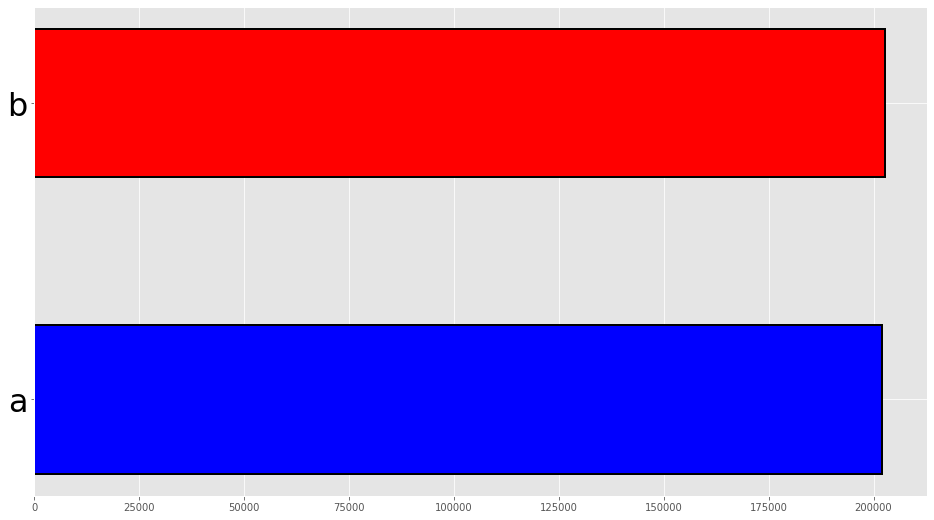

b=202667
a=202103


In [81]:
plt.figure()

plt.barh(y = gruppa['testgroup'],
         width = gruppa['count'],
         color = ['blue', 'red'],
         height = 0.5,
         edgecolor = 'black',
         linewidth = 2)

plt.yticks(color = 'black',
           fontsize = 32,
           family = 'sans-serif')



plt.show()

print("b=202667")
print("a=202103")

Найдем соотношение платящих пользователей к общему числу. Найдем Конверсию

In [43]:
buyers = []
for i in df['revenue']:
    if i == 0:
        x = 'no'
    else:
        x = 'yes'
    buyers.append(x)
df['buyers'] = buyers
df.head()

,user_id,revenue,testgroup,buyers
0,1,0,b,no
1,2,0,a,no
2,3,0,a,no
3,4,0,b,no
4,5,0,b,no


Сделаем сравнение платящих пользователей 

In [44]:
gruppa_buyers = df \
    .groupby(['buyers', 'testgroup'], as_index = False) \
    .agg({'user_id' : 'count'}) \
    .rename(columns = {'user_id' : 'count'}) \
    .sort_values('testgroup') \
    .reset_index(drop = True)
gruppa_buyers['combination'] = gruppa_buyers['buyers'] + '_' + gruppa_buyers['testgroup']
gruppa_buyers['percentage'] = round(gruppa_buyers['count'][:2] / gruppa_buyers['count'][:2].sum() * 100, 2)
gruppa_buyers['percentage'][2:] = round(gruppa_buyers['count'][2:] / gruppa_buyers['count'][2:].sum() * 100, 2)


Посчитаем ARPU для контрольной и тестовой групп

In [64]:
ARPU_control = df.query('testgroup == \"a\"').revenue.mean().round(2)
ARPU_test = df.query('testgroup == \"b\"').revenue.mean().round(2)
    
print('ARPU_control =',ARPU_control)
print('ARPU_test =',ARPU_test)
print(f'ARPU_test > ARPU_control на {round((ARPU_test-ARPU_control)/ARPU_test*100, 2)}%')

ARPU_control = 25.41
ARPU_test = 26.75
ARPU_test > ARPU_control на 5.01%


Построим распределения платящих пользователей для контрольной и тестовой групп, но теперь без учёта выбросов.

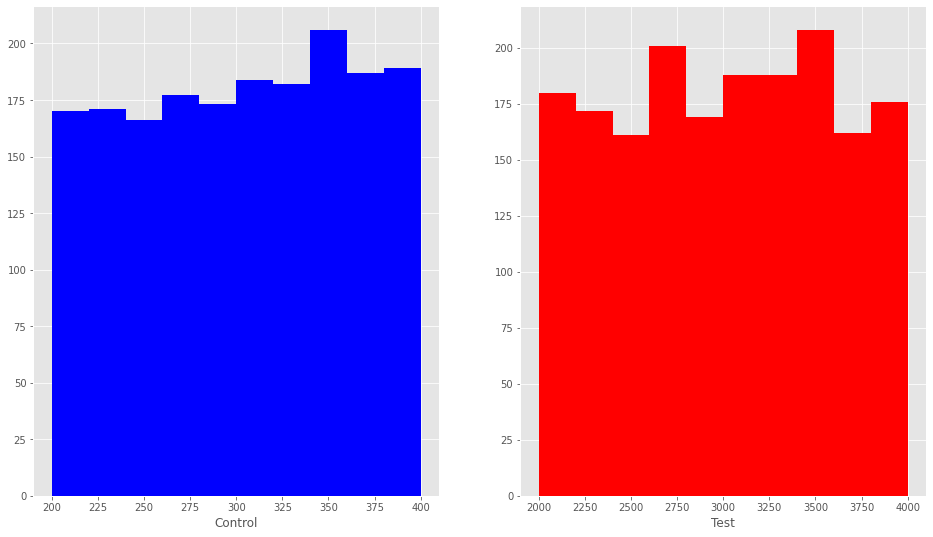

In [58]:
plt.subplot(1, 2, 1)
df.query('testgroup == \"a\" and 0 < revenue < 5000')['revenue'].hist(color='blue')
plt.xlabel('Control')
plt.subplot(1, 2, 2)
df.query('testgroup == \"b\" and revenue > 0')['revenue'].hist(color="red")
plt.xlabel('Test')
sns.despine()

По графикам видно, что, если не принимать во внимание выбросы в контрольной группе, то размах Revenue в контрольной группе 200 - 400, а в тестовой 2000 - 4000. Разница очевидна. Посчитаем точно

In [47]:
gruppa_buyers

,buyers,testgroup,count,combination,percentage
0,no,a,200175,no_a,99.05
1,yes,a,1928,yes_a,0.95
2,no,b,200862,no_b,99.11
3,yes,b,1805,yes_b,0.89


Видим, что в группе а конверсия выше, чем в группе б. Проверим статистическую значимость при помощи p-value

In [48]:
a = 0.05
stat, p = stats.chi2_contingency(pd.crosstab(df['testgroup'], df['buyers']))[:2]
if p < a:
    print('Нулевая гипотеза отклоняется, есть стат. значимое влияние')
else:
    print('Нулевая гипотеза не отклоняется, нет стат. значимого влияния')

Нулевая гипотеза отклоняется, есть стат. значимое влияние


In [49]:
stat, p = stats.chi2_contingency(pd.crosstab(df['testgroup'], df['buyers']))[:2]

In [50]:
stat

4.374729521260405

In [51]:
p

0.03647561892312613

Значение p=0.03 - это значит, что гипотеза о отсутсвиии виляния ивента на платящую группу отклоняется! Так как p меньше 0.05! Вывод: Ивент имеет влияние на платящих пользователей.

Считаем выручку на пользователя ARPU  ARPPU

In [52]:
arpu_by_group = round(df \
    .groupby('testgroup', as_index = False) \
    .agg({'revenue' : 'mean'}), 2)

arppu_by_group = round(df \
    .query('revenue > 0') \
    .groupby('testgroup', as_index = False) \
    .agg({'revenue' : 'mean'}), 2)


In [53]:
arpu_by_group

,testgroup,revenue
0,a,25.41
1,b,26.75


In [54]:
arppu_by_group

,testgroup,revenue
0,a,2664.00
1,b,3003.66


Видим, что в группе "b", средняя выручка на пользователя выше.

Изучим распределение выручки.

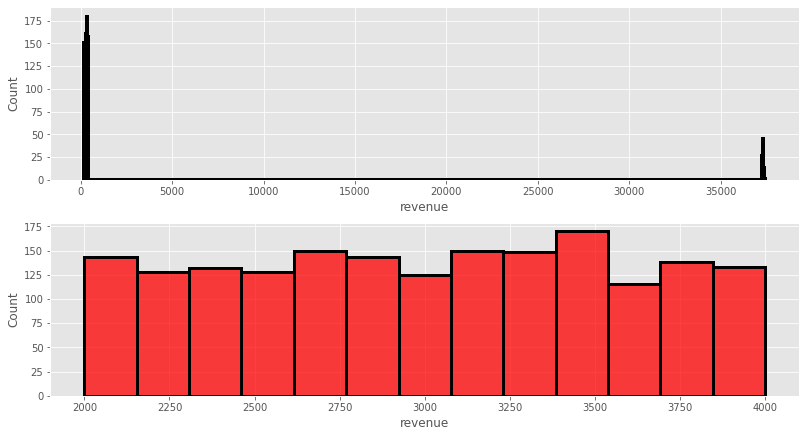

In [89]:
fig = plt.figure(figsize = (13, 3))

ax0 = fig.add_axes([0, 0, 0.8, 0.8])
ax1 = fig.add_axes([0, -1, 0.8, 0.8])

sns.histplot(df.query("testgroup == 'a' & revenue > 0")['revenue'],
               ax = ax0,
               color = 'blue',
               edgecolor = 'black',
               linewidth = 4)

sns.histplot(df.query("testgroup == 'b' & revenue > 0")['revenue'],
               ax = ax1,
               color = 'red',
               edgecolor = 'black',
               linewidth = 3)

Видим, что в группе "b", платящие платят более равномерно, чеки крепнее, по отношению к группе "a".

Необходимо понять, есть ли статистически значемые отклонения между ARPU и ARPPU
используем t test

In [56]:
a2 = 0.05
p = stats.ttest_ind(df.query("testgroup == 'a'")['revenue'], df.query("testgroup == 'b'")['revenue'], 
                    equal_var = False)[1]
print(p)
if p < a2:
    print('Нулевая гипотеза о равенстве средних отклонена')
else:
    print('Нуелвая гипотеза о равенстве средних не отклонена')

0.5329647014130866
Нуелвая гипотеза о равенстве средних не отклонена


t-test показал, что нет статистически значимой разницы между ARPU группы а и группы b.

Вывод: вывод неоднозначен получился, с одной стороны мы видим, что нововведение в виде ивента, повлияло на платящих людей в группах, в группе "а" покупают на 0.06% больше чем в группе "b", но в группе "b" платят достаточно равномерно, а в группе "а" есть всплеск резких и дорогих покупок. Так же мы наблюдаем отсутсвие статистически значимых отклонений при вычислении p value для ARPU, может ли это нам доказывать, что введение ивента не влияет на покупательскую способность. Вывод: ввести ивент для группы "b" - есть риск, что эти статистически значимые значения не имеют влияние на "ивент". 

### TASK 3

1. MAU - используем метрику для понимания кол-ва уникальных пользователей в месяц во время события
Узнаем сколько уже активных пользователей вспомнили про нашу игру благодаря данному ивену - мы разделим MAU / число всех клиентов в приложении и получим долю вернувшихся клиентов во время "ивента" 
Может зарегистрированным пользоватлям подарить пак бустеров.





2. Затем проверим а) Сколько новых пользователей в течении месяца зарегистрировались и прошли "ивент" до конца; б) Сколько активных пользователей прошли до конца "ивент"; тем самым мы узнаем насколько этот ивент понравился пользователям, может слишком трудный "ивент", может для новых клиентов он подходит, а для активных игроков будет не интересно(уже скучно). Тогда можно будет улучшить призы, увеличить сложность, подготовить более глубокий лор игры.
При помощи формулы ATTP - среднее время прохождения ивента мы узнаем event retention

3. Так же нам понадобится узнать сколько пользователей проигнорировали наше событие, даже ни разу не сыграв, нужно будет разобраться почему так произошло, если процент будет низкий 0.001%, то можно будет оптимизировать данную формулу "игнора" и сделать из этого формулу которая будет считать пользователей которые один раз сыграли в ивент и затем больше не играли, доля будет больше и так мы сможем вернее дать гипотезу почему клиентам не понравился ивент \
метрика Ignore rate

4. Затем нужно расчитать Revenue относящиеся исколючительно к собитыю/ивенту, сколько заработано за ивент, и вывести гипотезу, нужно ли добавлять донат например усиленная броня для финального босса, в случае с нашим садом наверное ускоренный рост растений. Или пользователи и так приобретают бустеры, или наоборот им так легко что не нужно донатить. Получичается нужно фиксить баги в ивенте, добавлять или убирать уровни сложности. Добавлять или убирать донаты.

Усложненная механика
1. В этом ивенте, где тебя откатывают назад за проигрыш, нужно понять насколько сложные уровни, то есть ввести метрику которая покажет на каком уровне сливается пользователь, и тем самым мы узнаем есть ли смысл отката, или игроку достаточно просто заходить в игру чаще, чтобы прокачать своих растений и они стали сильнее для того чтобы пройти тот уровень на котором ты вылетаешь. Мы узнаем, насколько пользователь вовлечен в игру, и трепетно прокачивает свои растения, может быть он после того как не прошел уровень, понял что у него слишком слабый сад и вовсе перехотел играть, так как расчитывает что не справится, или настолько легко, что вышел, так как нет конкуренции.
Lose level rate

Для проверки кол ва людей прошедших собите до конца с нвоой механикой по отношению к тем пользователям которые проходили по старой можно при помощи proportions_ztest() библиотека statsmodels.api

2. Так же будет интересно узнать среднедневное число попыток по отношению к средненельным запуском приложения, насколько часто игрок заходя в игру проигрывает и возвращается обратно, в неделю раз. Если мало, то есть один день играет неделю не играет, у игры слабая ежедневная "халява", ежедневные бонусы, еженедельные паки, зайди 7 раз подряд получи буст для цветка. Тем самым игрок сможет за ивент около 4 раз усилить свой сад и побороться на ивенте и выиграть даже с откатами, а если ему нужно будет просто заходить и по новой стараться обыграть противников без улучшений своих нынешних стаков растений, его это быстро расстроит и он уйдет.

Набор метрик можно использовать тот же, так как мы в целом ничего не меняем, у нас становится либо сложнее либо легче играть, сама задумка ивента не меняеся структура таже. Добавим метрики проигрыша пользователя и визуализируем для удобства, и добавим метрику попыток